In [2]:
from gradient_descent import gradient_descent, minibatch_class
import utils

import matplotlib.pyplot as plt
from pandas import read_csv
import math
from timeit import default_timer as timer
from tqdm import tqdm 
import time 


import numpy as np
import torch
from torch import nn
import scipy.linalg as SLA 
from scipy.linalg import toeplitz 
torch.set_default_dtype(torch.float64)

In [3]:
class Poisson_reg():
    '''
    Poisson regressor class. The purpose of this class is to initialize the PLN model.
    '''
    
    def __init__(self): 
        pass
    

    
    def fit(self,O,X,Y, Niter_max = 300, tol = 0.1, lr = 0.00008,  verbose = False): 
        '''
        We run a gradient ascent to maximize the log likelihood. We do this by hand : we compute the gradient ourselves. 
        The log likelihood considered is the one from a poisson regression model. It is the same as PLN without the latent layer Z. 
        We are only trying to have a good guess of beta before doing anything. 
        
        args : 
                '0' : offset, size (n,p)
                'X' : covariates, size (n,p)
                'Y' : samples , size (n,p)
                'Niter_max' :int  the number of iteration we are ready to do 
                'tol' : float. the tolerance criteria. We will stop if the norm of the gradient is less than 
                       or equal to this threshold
                'lr' : float. learning rate for the gradient ascent
                'verbose' : bool. if True, will print some stats on the 
                
        returns : None but update the parameter beta 
        '''
        
        #we initiate beta 
        beta = torch.rand(X.shape[1])
        i = 0
        grad_norm = 2*tol
        while i<Niter_max and  grad_norm > tol : # condition to keep going
            grad = grad_poiss_beta(O,X,Y,beta) # computes the gradient 
            grad_norm = torch.norm(grad) 
            beta += lr*grad_poiss_beta(O,X,Y,beta)# update beta 
            i+=1
            
            # some stats if we want some 
            if verbose == True : 
                if i % 10 == 0 : 
                    print('log likelihood  : ', compute_l(0,X,Y,beta))
                    print('Gradient norm : ', grad_norm)
        if i < Niter_max : 
            print('---------------------Tolerance reachedin {} iterations'.format(i))
        else : 
            print('---------------------Maximum number of iterations reached')
        print('----------------------Gradient norm : ', grad_norm)
        self.beta = beta # save beta 
        
        
    def fit_torch(self,O,X,Y, Niter_max = 300, tol = 0.1, lr = 0.0001, verbose = False): 
        '''
        Does exaclty the same as fit() but uses autodifferentiation of pytorch. 
        '''
        
        beta = torch.rand(X.shape[1], requires_grad = True)
        optimizer = torch.optim.Adam([beta], lr = lr)
        i = 0
        grad_norm = 2*tol
        while i<Niter_max and  grad_norm > tol :
            loss = -compute_l(O,X,Y,beta)
            loss.backward()
            optimizer.step()
            grad_norm = torch.norm(beta.grad)
            beta.grad.zero_()
            i+=1
            if verbose == True : 
                if i % 10 == 0 : 
                    print('log like : ', -loss)
                    print('grad_norm : ', grad_norm)
        if verbose :
            if i < Niter_max : 
                print('-------------------Tolerance reached in {} iterations'.format(i))
            else : 
                print('-------------------Maxium number of iterations reached')
        self.beta = beta 
    

def grad_poiss_beta(O,X,Y,beta): 
    return torch.sum(-torch.multiply(X,torch.exp(O+X@beta).reshape(-1,1))+torch.multiply(Y.reshape(-1,1),X),dim = 0)
    
def compute_l(O,X,Y,beta):
    return torch.sum(-torch.exp(O + X@beta)+torch.multiply(Y,O+X@beta))    
    
def sample(O,X,true_beta):
        parameter = np.exp(O + X@true_beta)
        return torch.poisson(parameter)

In [4]:
class sample_PLN(): 
    '''
    simple class to sample some variables with the PLN model. 
    The main method is the sample one, however we can also plot the data calling the plot_Y method. 
    The method conditional prior should not be used and have not been tested properly. 
    '''
    
    def __init__(self): 
        pass 

    def sample(self, Sigma, beta, O, covariates): 
        '''
        sample Poisson log Normal variables. 
        The number of samples is the the first size of O, the number of species
        considered is the second size of O
        The number of covariates considered is the first size of beta. 
        
        '''
        self.Sigma = Sigma # unknown parameter in practice
        self.beta = beta #unknown parameter in practice
        
        self.O = O 
        self.covariates = covariates
        
        self.Z = torch.stack([self.Sigma@np.random.randn(p) for _ in range(n)])
        
        self.n = self.O.shape[0]
        self.p = self.Sigma.shape[0]
        self.d = self.covariates.shape[1]
        
        parameter = torch.exp(self.O + self.covariates@self.beta + self.Z)
        self.Y = np.random.poisson(lam = parameter)
        return self.Y 
        #return parameter.numpy()
    def plot_Y(self): 
        '''
        plot all the Y_ij sampled before. There will be n*p values in total. The color represent the site number. 
        Note that we need to have called self.sample() before otherwise it won't print anything 
        '''
        color = np.array([[site]*self.p for site in range(self.n) ]).ravel()*10
        plt.scatter(np.arange(0,self.n*self.p),self.Y.ravel(), c = color, label = 'color = site number')
        plt.legend()
        plt.ylabel('count number')
        plt.show()

    def conditionalprior(self): 
        mu = self.O[0,0]
        functions = list()
        for i in range(self.n): 
            mu_i = self.covariates[i].dot(self.beta[0])
            functions.append(lambda z : -z**2/(2*self.Sigma[0,0]**2)-np.exp(mu_i+z)+float(self.Y[i])*(mu_i+z))
        return functions 

In [313]:
class PLNmodel(): 
    '''
    PLN model. The goal of this class is to compute the parameter beta and Sigma of the PLN model. 
    We use here variationnal approximation since we can't compute the log likelihood of the 
    latent variables given the data. 
    '''
    
    
    def __init__(self, Sigma_init, beta_init, M_init, S_init): 
        
        '''
            Initialization : 
            'Y' : the data, size (n,p). n is the number of samples we have and p the number of species. 
                  THE TYPE IS INT
            'O': offset : additional offset. (not very important for comprehension). size (n,p)
            'covariates' : covariates, size (n,d)
            'Sigma_init' : initialization for Sigma. I plan to do a more advanced initialization. 
            'beta_init ' : Initialization for beta. I plan to do a more advanced initialization. 
            'M_init' : initialization for the variational parameter M
            'S_init ': initialization for the variational parameter S
        '''
        
        # model parameters
        self.Sigma = torch.clone(Sigma_init)
        self.Sigma.requires_grad_(True)
        self.beta = torch.clone(beta_init)
        self.beta.requires_grad_(True)
        
        #variational parameters
        self.M = torch.clone(M_init)
        self.M.requires_grad_(True)
        self.S = torch.clone(S_init) 
        self.S.requires_grad_(True)
        
        # some useful variables
        self.det_Sigma = torch.det(self.Sigma)
        self.inv_Sigma = torch.inverse(self.Sigma)
        
        # optimizer for the VE_step
        self.VE_step_optimizer = torch.optim.Adam([self.S,self.M], lr = 0.01)
        self.VE_step_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.VE_step_optimizer, patience = 3, factor = 0.9)
        
        #optimizer for the M_step
        self.M_step_optimizer = torch.optim.Adam([self.beta])
        self.M_step_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.M_step_optimizer, patience = 3, factor = 0.9)        
        

    

        
    # we define here the gradients computed manually as a sanity check. We can check that they are equals 
    # to the gradients computed with the autodifferentiation of pytorch (diff = 1e-15)
    def grad_Sigma(self): 
        with torch.no_grad():
            self.inv_Sigma = torch.inverse(self.Sigma)
            grad = -self.n/2*(self.inv_Sigma)# + torch.diag(torch.diagonal(self.inv_Sigma))) on a enlevé car avec ça ca match avec pytorch. 
            grad += 1/2*(sum([self.inv_Sigma@(torch.outer(self.M[i,:],self.M[i,:])+ torch.diag(self.S[i,:]))@self.inv_Sigma  for i in range(self.n)]))
        return grad
    def grad_M(self): 
        with torch.no_grad():
            grad = -torch.mm(self.M,self.inv_Sigma)
            grad -= torch.exp(self.O + torch.mm(self.covariates,self.beta) + self.M + torch.pow(self.S,2)/2)
            grad += self.Y 
        return grad 
    def grad_S(self):
        with torch.no_grad():
            grad = -1/2*torch.mm(torch.ones((self.n,self.p)), torch.diag(torch.diag(self.inv_Sigma)))
            grad-= torch.mul(self.S,torch.exp(self.O + torch.mm(self.covariates,self.beta) + self.M + torch.pow(self.S,2)/2))
            grad += 1/2*torch.div(1,self.S)
        return grad 
    def grad_beta(self): 
        with torch.no_grad():
            grad = - torch.mm(self.covariates.T,torch.exp( self.O + self.M + torch.pow(self.S,2)/2 + torch.mm(self.covariates,self.beta)))
            grad += torch.mm(self.covariates.T,self.Y.double())
        return grad 
    
        
    def extract_data(self,data): 
        '''
        function to extract the data. This function is just here to have a code more compact. 
        
        args : 
              'data': list with 3 elements : Y, O and covariates in this order. 
        '''
        
        #known variables
        self.Y = data[0];self.O = data[1];self.covariates = data[2]
    
        self.n, self.p = self.Y.shape
    
        
    def compute_ELBO_bis(self, Y, covariates,O,M,S,Sigma,beta): 
        ''' 
        computes the ELBO. We simply apply the formula given above. 
        '''
        batch_size = Y.shape[0]
        inv_Sigma = torch.inverse(Sigma)
        tmp = -batch_size/2*torch.log(torch.det(Sigma))
        
        # formula with the quadratic function and the trace 
        tmp -=1/2*( torch.sum(torch.mm(torch.mm(M,inv_Sigma),M.T).diagonal()))   # we can simplify here, takes too much time 
                                                                                           # we should remove the diagonal and do a more efficient multiplication
                                            
                        
        Gram_matrix = torch.mm(covariates,beta) # matrix with term (i,j): <x_i,beta_j>
        
        Exp_moment = torch.exp(M + torch.pow(S,2)/2)
        
        tmp += torch.sum(-torch.exp(O + Gram_matrix + M + torch.pow(S,2)/2) + torch.multiply(Y, O + Gram_matrix + M))
        
        for i in range(batch_size): 
            tmp += 1/2* torch.log(S[i,:].prod())
            tmp -= 1/2 * torch.trace(torch.multiply(inv_Sigma,S[i,:]))
            
        return tmp
    
    
    def compute_ELBO(self): 
        ''' 
        computes the ELBO. We simply apply the formula given above. 
        '''
        
        inv_Sigma = torch.inverse(self.Sigma)
        tmp = -self.n/2*torch.log(torch.det(self.Sigma))
        
        # formula with the quadratic function and the trace 
        tmp -=1/2*( torch.sum(torch.mm(torch.mm(self.M,inv_Sigma),self.M.T).diagonal()))   # we can simplify here, takes too much time 
                                                                                           # we should remove the diagonal and do a more efficient multiplication
                                            
                        
        Gram_matrix = torch.mm(self.covariates,self.beta) # matrix with term (i,j): <x_i,beta_j>
        
        Exp_moment = torch.exp(self.M + torch.pow(self.S,2)/2)
        
        tmp += torch.sum(-torch.exp(self.O + Gram_matrix + self.M + torch.pow(self.S,2)/2) + torch.multiply(self.Y, self.O + Gram_matrix + self.M))
        
        for i in range(self.n): 
            tmp += 1/2* torch.log(self.S[i,:].prod())
            tmp -= 1/2 * torch.trace(torch.multiply(inv_Sigma,self.S[i,:]))
            
        return tmp
    
    def torch_gradient_ascent(self,optimizer, scheduler, params, params_names, lr = None, tolerance = 2, N_epoch = 500, verbose = True, batch_size = None ): 
        '''
        gradient ascent function. We compute the gradients thanks to the autodifferentiation of pytorch. 
        
        args : 
                'optimizer' : torch.optim.optimizer. the optimizer for the parameters. 
                'scheduler' : torch.optim.lr_scheduler.  scheduler for the optimizer above. 
                
                # I will generalize this with dictionnaries 
                'params' : torch.Tensor . the params we want to optimize. they should have required_grad = True. 
                'params_names' : the names of the parameter 
                
                'lr' : float.  a learning rate if we want to set the optimizer learning rate to a certain lr. If None, 
                      it will take the actual learning_rate of the optimizer. 
                'tolerance': float. the threshold we set to stop the algorithm. It will stop if the norm of each gradient's parameter 
                             is lower than this threshold, or if we are not improving the loss more than tolerance. 
                'N_epoch': int. the Maximum number of epoch we are ready to do. 
                
                'Verbose' : bool. if True, will print some messages useful to interpret the gradient ascent. If False, nothing will be printed. 
                
                'batch_size' : int or None. If None, the batch size will be n, so it will be a classical vanilla algorithm. 
                              if int, we will split the data set in batch size and do a gradient step for each mini_batch. 
                              
        
        returns : the parameters optimized. 
        '''
        
        
        # we set the gradient to zero just to make sure the gradients are properly calculated
        optimizer.zero_grad()
        
        if lr is not None : # if we want to set a threshold, we set it. Ohterwise, we skip this condition and keep the actual learning_rate
            optimizer.param_groups[0]['lr'] = lr 
            
        if batch_size == None : 
            batch_size = self.Y.shape[0]
        
        stop_condition = False 
        i = 0
        old_epoch_loss = 0
        while i < N_epoch and stop_condition == False: 
            epoch_loss = 0
            for Y_b, covariates_b, O_b, M_b, S_b in self.get_batch(batch_size): 
                optimizer.zero_grad()
                loss = -self.compute_ELBO_bis(Y_b, covariates_b, O_b, M_b, S_b,self.Sigma, self.beta)
                loss.backward()
                if torch.isnan(loss).item() == True : 
                    print('NAAAAAAAAN')
                
                else : self.last_param = [self.M, self.S, self.beta, self.Sigma]
                if verbose and i % 25 == 0 : 
                    self.print_stats(loss, params, params_names, optimizer)

                optimizer.step()
                i += 1
                epoch_loss += loss  
            scheduler.step(epoch_loss)
            
            # condition to see if we have reach the tolerance threshold
            if max([torch.norm(param.grad) for param in params]) < tolerance  or abs(epoch_loss.item() - old_epoch_loss) < tolerance : #and i > 10:
                #if max([torch.norm(param.grad) for param in params]) < tolerance  or abs(loss.item()- old_loss)>  tolerance :
                stop_condition = True 
            old_epoch_loss = epoch_loss
        self.current_ELBO = -loss.item()

        if verbose : # just print some stats if we want to 
            if stop_condition : 
                print('---------------------------------Tolerance reached in {} iterations'.format(i))
            else : 
                print('---------------------------------Maximum number of iterations reached')
            self.print_stats(loss, params, params_names, optimizer)    
        
        return params
        

    def print_stats(self, loss, params, params_names, optimizer): 
        '''
        small function that print some stats. 
        
        It will print the actual learning rate of the optimizer, the actual log likelihood 
        and the norms of each parameter's gradient. The norm of the parameter's gradient should be low
        when we are close to the optimum. 
        '''
        print('---------------------------------lr :', optimizer.param_groups[0]['lr'])
        print('---------------------------------log likelihood :', - loss.item())
        for param, param_name in zip(params,params_names): 
            print('---------------------------------grad_{}_norm : '.format(param_name), round(torch.norm(param.grad).item(), 3))
    
    def VEM(self,data, number_VEM_step ,batch_size,   beginning_VE_step_lr = 0.1, beginning_M_step_lr = 0.1, requires_init = False,N_epoch_VE = 20, N_epoch_M = 50): 
        '''
        function to optimize both the variational parameters and the model parameters.
        We alternate between two steps : Variational step (VE_step) and Maximization step (M_step). 
        
        
        args : 
            'number_VEM_step' : int . Number of times we want to do the VEM step, i.e. alternate between VE step and M step. 
                                The greater the better the approximation, the greater the longer time it takes. 
            
            'beginning_VE_step_lr' : float. the beginning of the learning for the VE_step. The VE will start with this lr. 
            'beginning_M_step_lr' : float. Same for beta, the M step will start with this lr. 
            
       returns : 
               M_S_lr, beta_lr : the learning rates of both steps, so that we can continue after that with the appropriate learning rates.  
        ''' 
        # we first extract the data. 
        self.extract_data(data)
        
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.ELBO_list = list()
        if requires_init : 
            print('Initialisation ... ')
            clf = Poisson_reg()
            for j in range(p): 
                Y_j = self.Y[:,j]   
                O_j = self.O[:,j]
                
                clf.fit_torch(O_j,self.covariates,Y_j, verbose = False , Niter_max = 500, lr = 0.1)
                with torch.no_grad():
                    self.beta[:,j] = clf.beta
            print('Initialisation finished')
    
        
        # we start with one VEM step with the appropriate learning_rate. We start with the M_step here 
        # since the log likelihood is Nan otherwise
        
        self.M_step(verbose = True, tolerance = 0.1, N_epoch = N_epoch_M, lr = beginning_M_step_lr)
        self.VE_step(verbose = True, tolerance = 0.1, N_epoch = N_epoch_VE, lr = beginning_VE_step_lr)

        
        # we do as many VEM_step we are asked to. 
        for i in range(number_VEM_step): 
            self.M_step(verbose = False, tolerance = 0.1, N_epoch = N_epoch_M, batch_size = batch_size)
            self.VE_step(verbose = False, tolerance = 0.1, N_epoch = N_epoch_VE)
            
            self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.ELBO_list.append(self.current_ELBO)
            print('-------UPDATE-------')
            print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
            print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
            print('ELBO : ', np.round(self.current_ELBO,5))

            
        return self.VE_step_optimizer.param_groups[0]['lr'],self.M_step_optimizer.param_groups[0]['lr']
        
    def VE_step(self, lr = None, tolerance = 2, N_epoch = 200, verbose = True  ): 
        '''
        VE_step : optimize the variational parameter. 
        We don't have a closed form for the parameters M and S so we have to do a gradient 
        ascent to do optimize them. 
        
        args : 
             'lr' : learning if we want to set the learning rate of the optimizer
        '''
        
        self.torch_gradient_ascent(self.VE_step_optimizer, self.VE_step_scheduler, [self.M,self.S], ['M', 'S'], lr = lr,
                                    tolerance= tolerance, N_epoch= N_epoch, verbose= verbose)
    def M_step(self,  lr = None, tolerance = 2, N_epoch = 50, verbose = True, batch_size = None):
        
        '''
        Optimize the model parameters. 
        We have a closed form for Sigma so we actually don't need to do a gradient ascent for Sigma, just apply the formula. 
        We do a gradient ascent for beta. 
        '''
        # closed form for Sigma, we don't need to optimize
        with torch.no_grad(): 
            self.Sigma = 1/self.n*(torch.sum(torch.stack([torch.outer(self.M[i,:],self.M[i,:]) + torch.diag(self.S[i,:])  for i in range(self.n)]), axis = 0))
        
            
            #self.beta = torch.mm(torch.inverse(torch.mm(self.covariates.T,self.covariates)),torch.mm(self.covariates.T,self.M))
            #print('grad : ', self.grad_beta())
        #print('grad :', self.beta.grad)

        # gradient ascent to optimize beta, the model parameter
        self.torch_gradient_ascent(self.M_step_optimizer, self.M_step_scheduler, [self.beta], ['beta'], 
                                   lr = lr, tolerance = tolerance, N_epoch= N_epoch, verbose= verbose, batch_size = batch_size )

   
    def get_batch(self,batch_size): 
        
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        nb_full_batch, last_batch_size  = self.n//batch_size, self.n % batch_size  
        self.batch_size = batch_size
        for i in range(nb_full_batch): 
            yield   (self.Y[indices[i*batch_size: (i+1)*batch_size]], 
                    self.covariates[indices[i*batch_size: (i+1)*batch_size]],
                    self.O[indices[i*batch_size: (i+1)*batch_size]], 
                    self.M[indices[i*batch_size: (i+1)*batch_size]], 
                    self.S[indices[i*batch_size: (i+1)*batch_size]])
                  
        if last_batch_size != 0 : 
            self.batch_size = last_batch_size
            yield   (self.Y[indices[-last_batch_size:]], 
                    self.covariates[indices[-last_batch_size:]],
                    self.O[indices[-last_batch_size:]],
                    self.M[indices[-last_batch_size:]], 
                    self.S[indices[-last_batch_size:]])

In [323]:
model_batch  = PLNmodel(Sigma_init, beta_init, M_init, S_init)
%time model_batch.VEM(data, number_VEM_step = 2500,batch_size = 25, N_epoch_VE = 100, N_epoch_M = 100, beginning_VE_step_lr=0.002, beginning_M_step_lr = 0.05 )

---------------------------------lr : 0.05
---------------------------------log likelihood : -44245.30839134192
---------------------------------grad_beta_norm :  396922.652
---------------------------------lr : 0.05
---------------------------------log likelihood : 589158.47755974
---------------------------------grad_beta_norm :  20382.237
---------------------------------lr : 0.05
---------------------------------log likelihood : 626077.2420393559
---------------------------------grad_beta_norm :  8206.35
---------------------------------lr : 0.05
---------------------------------log likelihood : 639099.2229562546
---------------------------------grad_beta_norm :  4379.653
---------------------------------Maximum number of iterations reached
---------------------------------lr : 0.05
---------------------------------log likelihood : 644771.2879674963
---------------------------------grad_beta_norm :  2824.483
---------------------------------lr : 0.002
------------------------------

(4.930069409916143e-06, 0.00607883272952847)

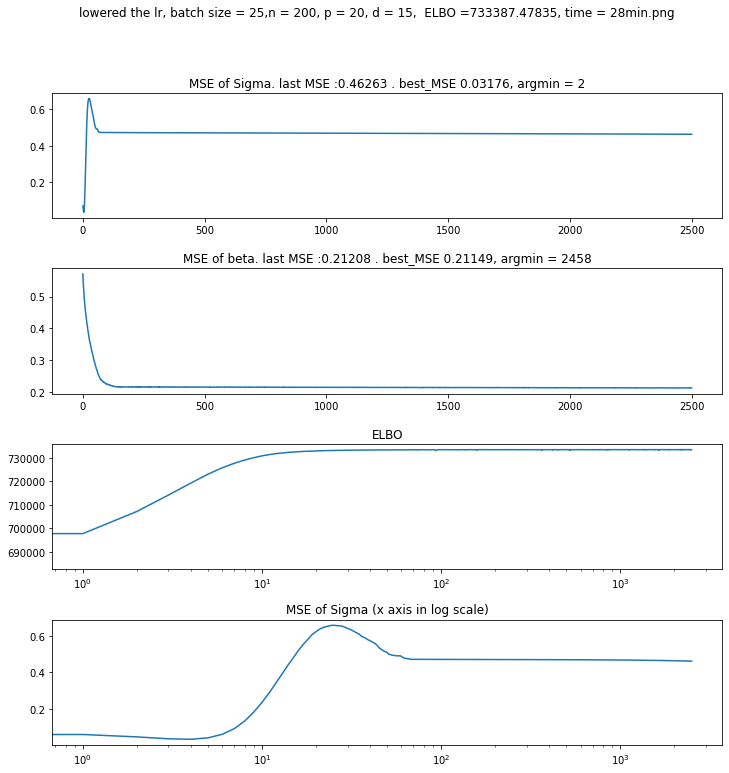

In [329]:
save_model(model_batch, batch_size = 25, time ='28min')

In [321]:
model = PLNmodel(Sigma_init, beta_init, M_init, S_init)
%time model.VEM(data, number_VEM_step = 2500,batch_size = None, N_epoch_VE = 100, N_epoch_M = 100, beginning_VE_step_lr=0.005, beginning_M_step_lr = 0.1 )

---------------------------------lr : 0.1
---------------------------------log likelihood : -44245.308391341896
---------------------------------grad_beta_norm :  396922.652
---------------------------------lr : 0.1
---------------------------------log likelihood : 610952.3460541735
---------------------------------grad_beta_norm :  13604.806
---------------------------------lr : 0.1
---------------------------------log likelihood : 640189.9049977921
---------------------------------grad_beta_norm :  6256.578
---------------------------------lr : 0.1
---------------------------------log likelihood : 648609.3825031879
---------------------------------grad_beta_norm :  2279.354
---------------------------------Maximum number of iterations reached
---------------------------------lr : 0.1
---------------------------------log likelihood : 650967.0558353803
---------------------------------grad_beta_norm :  1241.969
---------------------------------lr : 0.005
-------------------------------

(0.005, 0.03874204890000002)

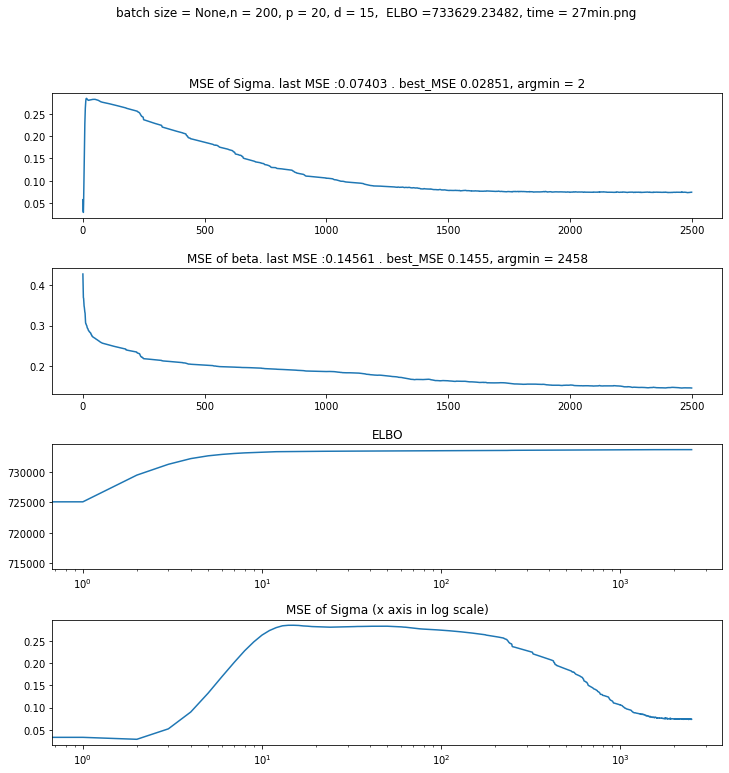

In [322]:
save_model(model, batch_size = None, time = '27min')

In [6]:
#extraction des données 
Y_tricho = torch.from_numpy(read_csv('trichoptera.csv', sep=',').to_numpy())
O_tricho = torch.outer(Y_tricho.sum(1), torch.ones(Y_tricho.shape[1]))/1000

n_tricho,p_tricho = Y_tricho.shape 
d_tricho = 4
covariates_tricho = torch.ones((n_tricho,d_tricho)) # attention prendre que des 1 n'est pas une bonne solution

data_tricho = [Y_tricho,O_tricho, covariates_tricho]

In [309]:
d = 15 # nb of cavariates
n = 200; p = 20

In [310]:
true_Sigma = torch.from_numpy(toeplitz(0.5**np.arange(p)))
true_beta = torch.randn(d, p)


covariates = torch.rand((n,d))
O = 1 + torch.zeros((n,p))

sample_model = sample_PLN()
Y_sampled = torch.from_numpy(sample_model.sample(true_Sigma,true_beta, O, covariates)) 

data = [Y_sampled, O, covariates]

In [311]:
torch.manual_seed(1)

noise = torch.randn(p,p) 
Sigma_init =  (noise+ noise.T)
beta_init = torch.rand((d, p))

M_init = torch.ones((n,p))/100# some random values to initialize we divide to avoid nan values 
S_init = torch.ones((n,p))/8 # some random values to initializ. we divise to avoid nan values 

In [330]:
def save_model(modele, batch_size, time): 
    n,p = modele.Y.shape
    d = modele.beta.shape[0]
    ELBO = np.round(modele.current_ELBO,5)
    name = 'batch size = {},n = {}, p = {}, d = {},  ELBO ={}, time = {}.png'.format(batch_size, n,p,d, ELBO, time )
    abscisse = np.arange(len(modele.MSE_Sigma_list))
    fig,ax = plt.subplots(4,1,figsize = (12,12))
    ax
    plt.subplots_adjust(hspace = 0.4)
    plt.suptitle(name)
    ax[0].plot(abscisse, modele.MSE_Sigma_list)
    Sigma_min = np.round(min(modele.MSE_Sigma_list),5)
    Sigma_argmin = np.argmin(model.MSE_Sigma_list)
    ax[0].set_title('MSE of Sigma. last MSE :{} . best_MSE {}, argmin = {}'.format(np.round(modele.MSE_Sigma_list[-1],5), Sigma_min, Sigma_argmin))
    
    ax[1].plot(abscisse, modele.MSE_beta_list)
    beta_min = np.round(min(modele.MSE_beta_list),5)
    beta_argmin = np.argmin(model.MSE_beta_list)
    ax[1].set_title('MSE of beta. last MSE :{} . best_MSE {}, argmin = {}'.format(np.round(modele.MSE_beta_list[-1],5), beta_min, beta_argmin))
    
    ax[2].plot(abscisse, modele.ELBO_list)
    ax[2].set_xscale('log')
    ax[2].set_title('ELBO')
    
    ax[3].plot(abscisse, modele.MSE_Sigma_list)
    ax[3].set_title('MSE of Sigma (x axis in log scale)')
    ax[3].set_xscale('log')
    plt.savefig(name)

sizes : 

$ Y : (n,p)$ 

$O : (n,p)$ 

$\Sigma :  (p,p)$ 

covariates ($x$) : $(n,d)$

$\beta : (d,p)$

$M : (n,p)$

$S : (n,p)$ . Should be seen as $(n,p,p)$ but since all the $n$  matrix $(p,p)$ are diagonal, we only need $p$ points to encode it.


d = 2 # nb of cavariates
n = 200; p = 50


Does not work very well : 

$MSE_{Sigma} = 1.15$ : probably stock in a local minima. 
$MSE_{beta} = 0.95$
lr = 0.1 for both 
***

d = 5 # nb of cavariates
n = 200; p = 50

lr = 0.01 for VE step
LR = 0.1 for M_step
added an init for beta : 

MSE with Sigma :  0.10714
MSE with beta :  0.12845

result after 250 VEM step. 

took about 25 minutes

***
Same as above but without inittialization for beta : 

 MSE with Sigma :  0.08429
 MSE with beta :  0.12089
 
 we can go to 0.06 and 0.11 if we go 50 step more 


## The Poisson lognormal (PLN) model


- Consider $n$ sites $(i=1 \ldots n)$

- Measure $x_{i}=\left(x_{i h}\right)_{1 \leq h \leq d}$ :
$x_{i h}=$ given environmental descriptor (covariate) for site $i$
(altitude, temperature, latitude, ...)

- Consider $p$ species $(j=1 \ldots p)$ Measure $Y=\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ :

- Measure $Y = Y_{i j}=$ number of observed individuals from species $j$ in site $i$ (abundance). 

- Associate a random vector $Z_{i}$ with each site Assume that the unknown $\left(Z_{i}\right)_{1 \leq i \leq n}$ are iid (no spatial structure):
$$
Z_{i} \sim \mathcal{N}_{p}(0, \Sigma)
$$
- Assume that the observed abundances $\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ are independent conditionally on the $Z=\left(Z_{i}\right)_{i}$


$$
\left(Y_{i j} \mid Z_{i j}\right) \sim \mathcal{P}\left(\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+Z_{i j}\right)\right)
$$


The parameter of the model is $\theta = (\beta, \Sigma)$. 

Since the model depends on latent variables, we want to apply the EM algortihm. However, EM requires to compute the following : 

$$
\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y\right)\right]=\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y_{i}\right)\right] \propto \int_{\mathbb{R}^{p}} p_{\Sigma}\left(Z_{i}\right) \prod_{j} p_{\theta}\left(Y_{i j} \mid Z_{i j}\right) \mathrm{d} Z_{i}
$$

Which is intractable in practice. 

We have two alternatives here. The first one is an approximation of this integral via MCMC methods. The second one is the variationnal approach. We adopt here the second approach. 

The goal of variationnal approach is to approximate $p_{\theta}(Z \mid Y)$ with some law $q^{\star}(Z)$ from which we can compute the expectation with respect to $\theta$. 


We find such a law by maximizing the Evidence Lower BOund (ELBO), that is : 
$$ 
q^{\star} = \underset{q \in \mathcal{Q}}{\operatorname{argmax}} J_{\theta,q}(Y) 
$$
<br>
$$
\begin{align} J_{\theta, q}(Y)& =\log p_{\theta}(Y)-K L\left[q(Z) \| p_{\theta}(Z \mid Y)\right]                                    \\ 
                              & = \mathbb{E}_{q}\left[\log p_{\theta}(Y, Z)\right] \underbrace{-\mathbb{E}_{q}[\log q(Z)]}_{\text {entropy } \mathcal{H}(q)}    \end{align}
$$


Where $\mathcal{Q}$ is a set of distributions. 
The Variational EM (VEM) consists in alternate between two steps : 
- VE step: update $q$
$$
q^{h+1}=\underset{q \in \mathcal{Q}}{\arg \max } J_{\theta^{h}, q}(Y)=\underset{q \in \mathcal{Q}}{\arg \min } K L\left[q(Z) \| p_{\theta^{h}}(Z \mid Y)\right]
$$
- M step: update $\theta$
$$
\theta^{h+1}=\underset{\theta}{\arg \max } J_{\theta, q^{h+1}}(Y)=\underset{\theta}{\arg \max } \mathbb{E}_{q^{h+1}}\left[\log p_{\theta}(Y, Z)\right]
$$

# VEM for PLN 

We consider 
$$
\mathcal{Q}_{\text {Gauss }}=\{q: q=\mathcal{N}(m, S)\}
$$

The parameters $M = (m_i)_{1\leq i \leq n} \in \mathbb{R}^{n\times p}$  and $ S = (S_i)_{1\leq i \leq n} \in \mathbb{R}^{n\times p} $ are called variational parameters whereas $\theta = (\beta,\Sigma)$ is called model parameter.  

The ELBO can be computed as : 


<br>
<br>


$$
\begin{aligned}
J_{\theta, q}(Y)=& \sum_{i} \mathbb{E}_{q_{i}}\left[\log p_{\theta}\left(Z_{i}\right)\right]+\sum_{i} \mathbb{E}_{q_{i}}\left[\log p_{\theta}\left(Y_{i} \mid Z_{i}\right)\right]+\sum_{i} \mathcal{H}\left[\mathcal{N}\left(m_{i}, S_{i}\right)\right] \\
=&-\frac{n}{2} \log |\Sigma|-\frac{1}{2} \sum_{i} \mathbb{E}_{\mathcal{N}\left(\cdot m_{i}, S_{i}\right)}\left[Z_{i}^{\top} \Sigma^{-1} Z_{i}\right] \\
&+\sum_{i, j} \mathbb{E}_{\mathcal{N}\left(\cdot ; m_{i}, S_{i}\right)}\left[-\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+Z_{i j}\right)+Y_{i j}\left(o_{i j}+x_{i}^{\top} \beta_{j}+Z_{i j}\right)\right] \\
&+\frac{1}{2} \sum_{i} \log \left|S_{i}\right|+\mathrm{cst}
\end{aligned}
$$
We can evaluate some moments of $Z$ : 
$$
\begin{aligned}
\mathbb{E}_{\mathcal{N}\left(\cdot ; m_{i}, s_{i}\right)}\left(Z_{i}\right) &=m_{i}, & \mathbb{E}_{\mathcal{N}\left(\cdot ; m_{i}, S_{i}\right)}\left(Z_{i}^{\top} \Sigma^{-1} Z_{i}\right)=m_{i}^{\top} \Sigma^{-1} m_{i}+\operatorname{tr}\left(\Sigma^{-1} S_{i}\right) \\
\mathbb{E}_{\mathcal{N}\left(\cdot ; m_{i}, S_{i}\right)}\left(e^{Z_{i j}}\right) &=\exp \left(m_{i j}+\left[S_{i}\right]_{j j}^{2} / 2\right) &
\end{aligned}
$$

We then get : 

$$
\begin{aligned}
J_{\theta, q}(y) &=-\frac{n}{2} \log |\Sigma|-\frac{1}{2} \sum_{i} m_{i}^{\top} \Sigma^{-1} m_{i}+tr\left(\Sigma^{-1} S_{i}\right) \\
&+\sum_{i, j}-\exp \left(o_{i j}+x_{i}^{T} \beta_{j}+m_{i j}+\left[S_{i}\right]_{j j}^{2} / 2\right)+Y_{i j}\left(o_{i j}+x_{i}^{T} \beta_{j}+m_{i j}\right) \\
&+\frac{1}{2} \sum_{i} \log \left|S_{i}\right|+c s t .
\end{aligned}
$$


% the problem is convex if the S_i are diagonals. %

We have a closed form for the $\Sigma$ step, that is : 

$$
\widehat{\Sigma}=\frac{1}{n} \sum_{i}\left(m_{i} m_{i}^{\top}+S_{i}\right)
$$

For $\beta$, we have the following : 



$$
\nabla _{\beta}=-X^{\top} \exp \left(0+M+\frac{S \odot S}{2}+X \beta\right)+\frac{1}{2} X^{\top} Y
$$

However, we don't have any closed form for the VE step. 

We consider now $S$ as $(n,p)$ matrix. Indeed, the $S_i$ are supposed diagonal matrices so we only need $p$ points to encode each of them. Considering $S$ this way is simpler for calculus. Here are the gradients with respect to the variational parameters. 

$$
\nabla_{M} J=-M \Sigma^{-1}-\exp \left(O+x \beta+M+\frac{S \odot S}{2}\right)+Y
$$

$$
\nabla_{S} J=-\frac{1}{2}\mathbb{1}_{n}\mathbb{1}_{p}^{T} D_{\Sigma^{-1}}-S\odot  \exp \left(0+X \beta+M+\frac{S \odot  S}{2}\right)+\frac{1}{2} \frac{1}{S}
$$


We denote $D_{\Sigma^{-1}}$ the diagonal matrix composed of the diagonal of $\Sigma^{-1}$. The exponential is applied component-wise, as well as the division $\frac 1 S$. 












In [262]:
print('beta of the model : \n', model.beta)
print('true_beta : \n', true_beta)
print('\n \n \n')
print('Sigma of the model : \n', model.Sigma)
print('true_Sigma : \n', true_Sigma)

beta of the model : 
 tensor([[ 1.3317,  1.1693, -0.7714, -0.3931,  0.0435,  0.0249,  1.1270],
        [ 0.2621, -2.2377, -0.7254, -1.3219, -0.3614, -0.8606,  0.7364],
        [ 0.9908,  1.3611,  0.3054, -0.1442, -0.6935, -0.0047, -0.5331],
        [-0.4578,  2.0091, -0.9855,  1.7188,  0.3636, -0.1286, -1.5100],
        [-0.6545, -0.9745,  0.9794,  0.1433, -0.9164, -0.8507, -0.3245]],
       requires_grad=True)
true_beta : 
 tensor([[ 1.5286,  1.3868, -0.4622, -1.1306, -0.5680, -0.1138,  0.9410],
        [ 0.8277, -2.0033, -0.6267, -0.7433,  0.4777, -0.7171,  1.0790],
        [ 0.9449,  0.9672,  0.1545, -0.5985, -1.0944, -0.1459, -0.8818],
        [-0.9332,  1.6057, -1.2102,  1.4245,  0.0943,  0.4571, -0.8471],
        [-1.0952, -0.6439,  0.9200,  0.4530, -0.6434, -1.6909, -0.6297]])

 
 

Sigma of the model : 
 tensor([[ 1.5357,  1.1168,  0.8311,  0.3202,  0.0990, -0.2129, -0.0918],
        [ 1.1168,  1.6791,  1.1148,  0.6198,  0.4701,  0.0762,  0.2010],
        [ 0.8311,  1.1148,  1.

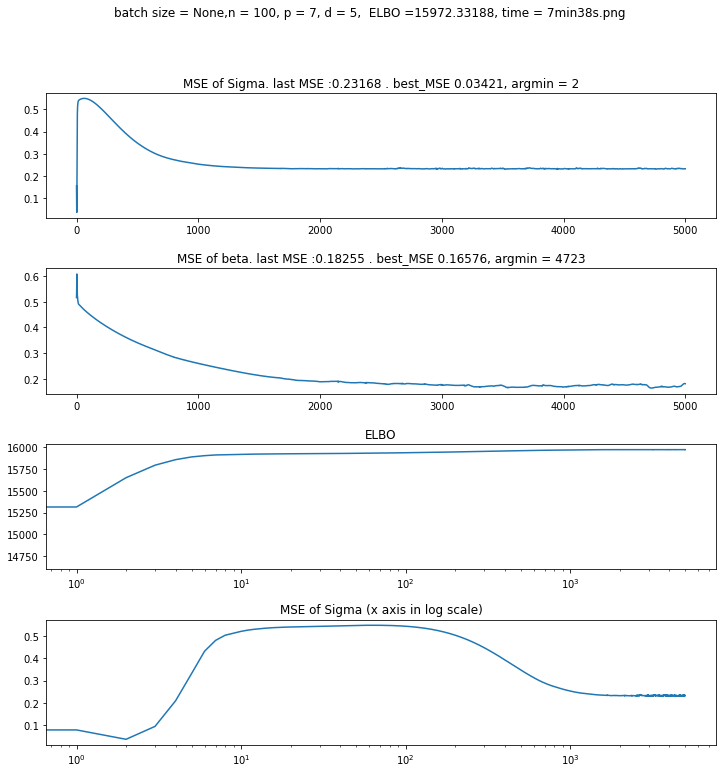

In [305]:

    
    
save_model(model, batch_size = None, time =  '7min38s')

